# Temperature timeseries from LMR at glacier locations 

In [1]:
# Data wrangling libs
import xarray as xr
import numpy as np
import pandas as pd
from scipy import stats
# Just for download and fancy bar
from oggm import utils
import progressbar
# Plots
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation 

In [2]:
fp = '/home/data/download/atmos.washington.edu/~hakim/lmr/LMRv2/air_MCruns_ensemble_mean_LMRv2.1.nc'

In [3]:
ds = xr.open_dataset(fp, chunks={'time':100})

In [4]:
air = ds.air.mean(dim='MCrun').load()

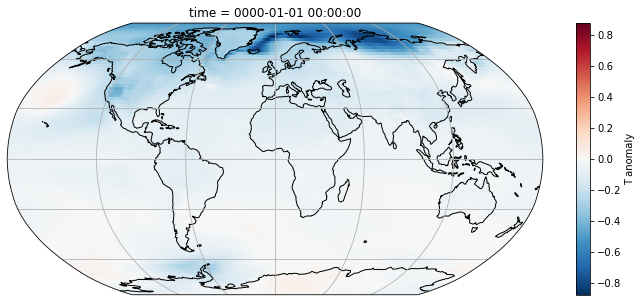

In [5]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
air.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'T anomaly'}) 
ax.coastlines(); ax.gridlines(); 

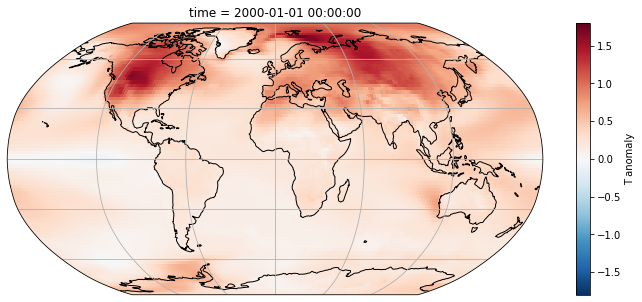

In [6]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
air.isel(time=-1).plot(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'T anomaly'}) 
ax.coastlines(); ax.gridlines(); 

### Glacier location and area

We download data from the [Randolph Glacier Inventory (RGI 6.0)](https://www.glims.org/RGI/), pre-processed in tabular form:

In [7]:
# RGI statistics as csv
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.csv')
odf = pd.read_csv(frgi, index_col=0,
                  converters={'Name':str, 'GLIMSId': str, 'BgnDate':str, 'EndDate':str, 
                              'O1Region': str, 'O2Region':str, 
                              'IsTidewater':bool, 'IsNominal':bool})

Some data wrangling to locate the LMR grid points where we have glaciers:

In [8]:
nx, ny = ds.dims['lon'], ds.dims['lat']
# Nearest neighbor lookup
cenlon_for_bins = np.where(odf['CenLon'] < -1, odf['CenLon']+360, odf['CenLon'])
lon_bins = np.linspace(-1, 359, nx+1)
lat_bins = np.linspace(-90-1, 90+1, ny+1)
odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of LMR gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

Total number of glaciers: 216502 and number of LMR gridpoints with glaciers in them: 874


### 2D masks for mapping and weighted averages 

Glacier locations and corresponding weights:

In [9]:
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area']
ds['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))
ds['glacier_area'] = (('lat', 'lon'), mask)
ds['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

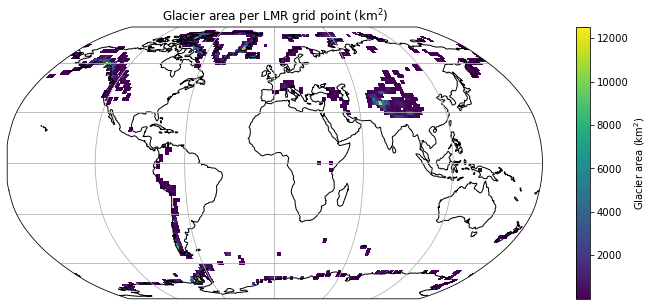

In [10]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
ds['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                        cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per LMR grid point (km$^{2}$)');

In [12]:
for m in range(1, 20):
    # RGI statistics as csv
    frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.csv')
    odf = pd.read_csv(frgi, index_col=0,
                      converters={'Name':str, 'GLIMSId': str, 'BgnDate':str, 'EndDate':str, 
                                  'O1Region': str, 'O2Region':str, 
                                  'IsTidewater':bool, 'IsNominal':bool})
    # Region selection
    odf = odf.loc[odf['O1Region'] == f'{m:02d}']
    nx, ny = ds.dims['lon'], ds.dims['lat']
    # Nearest neighbor lookup
    cenlon_for_bins = np.where(odf['CenLon'] < -1, odf['CenLon']+360, odf['CenLon'])
    lon_bins = np.linspace(-1, 359, nx+1)
    lat_bins = np.linspace(-90-1, 90+1, ny+1)
    odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
    odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
    # Use unique grid points as index and compute the area per location
    odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
    mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
    mdf['Area'] = odf.groupby('unique_id').sum()['Area']
    print('Total number of glaciers: {} and number of LMR gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))
    
    mask = np.full((ny, nx), np.NaN)
    mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area']
    ds[f'glacier_mask_{m:02d}'] = (('lat', 'lon'), np.isfinite(mask))
    ds[f'glacier_area_{m:02d}'] = (('lat', 'lon'), mask)
    ds[f'weight_glacier_{m:02d}'] = (('lat', 'lon'), mask / np.nansum(mask))

Total number of glaciers: 27108 and number of LMR gridpoints with glaciers in them: 60
Total number of glaciers: 18855 and number of LMR gridpoints with glaciers in them: 60
Total number of glaciers: 4556 and number of LMR gridpoints with glaciers in them: 65
Total number of glaciers: 7415 and number of LMR gridpoints with glaciers in them: 31
Total number of glaciers: 20261 and number of LMR gridpoints with glaciers in them: 124
Total number of glaciers: 568 and number of LMR gridpoints with glaciers in them: 10
Total number of glaciers: 1615 and number of LMR gridpoints with glaciers in them: 22
Total number of glaciers: 3417 and number of LMR gridpoints with glaciers in them: 20
Total number of glaciers: 1069 and number of LMR gridpoints with glaciers in them: 44
Total number of glaciers: 5151 and number of LMR gridpoints with glaciers in them: 89
Total number of glaciers: 3927 and number of LMR gridpoints with glaciers in them: 16
Total number of glaciers: 1888 and number of LMR gr

The Earth is not flat: take this into account as well:

In [13]:
# Weight
weight = np.cos(np.deg2rad(ds.lat)).clip(0)
weight =  air.isel(time=0) * 0. + weight
ds['weight'] = (('lat', 'lon'), weight / weight.sum())

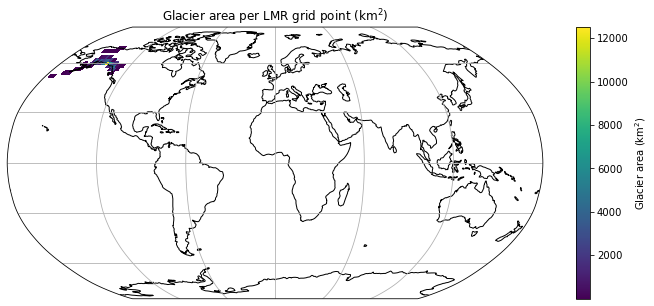

In [14]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
ds['glacier_area_01'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                        cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per LMR grid point (km$^{2}$)');

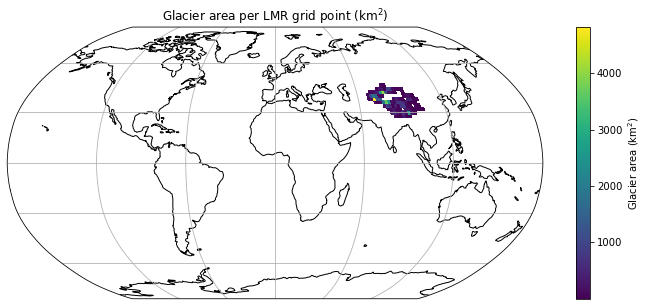

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
ds['glacier_area_13'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                        cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per LMR grid point (km$^{2}$)');

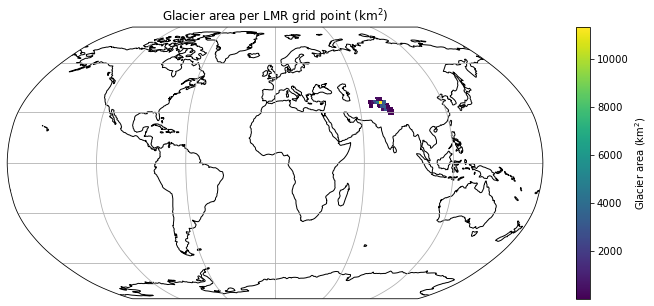

In [16]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes(projection=ccrs.Robinson())
ds['glacier_area_14'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                        cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per LMR grid point (km$^{2}$)');

### Temperature timeseries at glacier location 

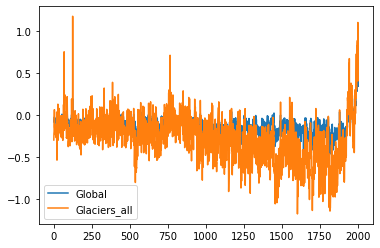

In [17]:
ts_global = (air * ds.weight).sum(dim=['lon','lat']).to_dataframe(name='Global')
ts_global['Glaciers_all'] = (air * ds.weight_glacier).sum(dim=['lon','lat']).to_series()
ts_global.index = np.arange(0, 2001)
ts_global.plot();

In [25]:
for m in range(1, 20):
    # RGI statistics as csv
    rs = f'{m:02d}'
    ts_global['RGI'+rs] = (air * ds[f'weight_glacier_{rs}']).sum(dim=['lon','lat']).to_series().values

In [30]:
ts_global.index.name = 'Year'

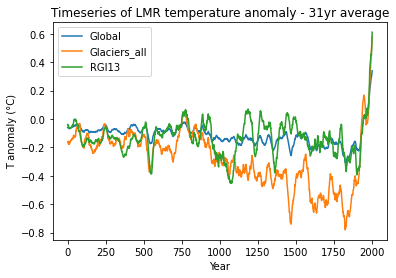

In [35]:
ts_global[['Global', 'Glaciers_all', 'RGI13']].rolling(window=31, center=True, min_periods=1).mean().plot();
plt.title('Timeseries of LMR temperature anomaly - 31yr average');
plt.ylabel('T anomaly (°C)');

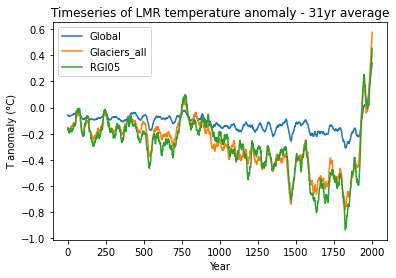

In [36]:
ts_global[['Global', 'Glaciers_all', 'RGI05']].rolling(window=31, center=True, min_periods=1).mean().plot();
plt.title('Timeseries of LMR temperature anomaly - 31yr average');
plt.ylabel('T anomaly (°C)');

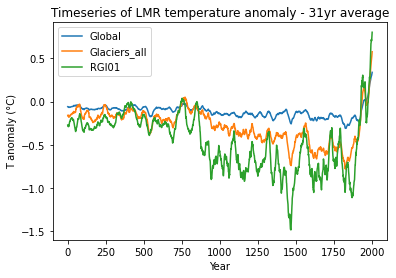

In [37]:
ts_global[['Global', 'Glaciers_all', 'RGI01']].rolling(window=31, center=True, min_periods=1).mean().plot();
plt.title('Timeseries of LMR temperature anomaly - 31yr average');
plt.ylabel('T anomaly (°C)');

In [33]:
ts_global.to_csv('lmr_timeseries_at_glaciers_annual.csv')
ts_global.rolling(window=31, center=True, min_periods=1).mean().to_csv('lmr_timeseries_at_glaciers_31yr_avg.csv')